# **Deep Learning HW4**

**Emirhan ÇETİNTÜRK**

**152120201124**

---


Colaboratory'nin Drive ile iletişimine izin verildi. Sonraki adımda ise CaltechTinySplit isimli ZIP dosyasının içeriği aynı isme sahip bir klasöre çıkartıldı.

In [1]:
if 0:
  from google.colab import drive
  #drive.flush_and_unmount()
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if 0:
    ! cp /content/drive/MyDrive/CaltechTinySplit.zip /content/
    ! unzip CaltechTinySplit.zip -d /content/CaltechTinySplit

Archive:  CaltechTinySplit.zip
   creating: /content/CaltechTinySplit/CaltechTinySplit/
   creating: /content/CaltechTinySplit/CaltechTinySplit/test/
   creating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/image_0024.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/image_0035.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/image_0037.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/image_0040.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/image_0046.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/camera/Thumbs.db  
   creating: /content/CaltechTinySplit/CaltechTinySplit/test/cannon/
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/cannon/image_0024.jpg  
  inflating: /content/CaltechTinySplit/CaltechTinySplit/test/cannon/image_0035.jpg  
  inflating: /content/CaltechTinySpli



---

Keras için gerekli Tensorflow eklentilerinin bulunduğu kütüphane kuruldu.


---



In [3]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


---

İşlemlerin daha hızlı gerçekleştirilebilmesi için program GPU ile çalıştırıldı. Bunun için "nvidia-smi" komutu konfigürasyon için çalıştırıldı.

---

In [4]:
!nvidia-smi  # GPU Configuration

Mon Dec  5 13:52:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

Gerekli kütüphaneler eklendi. Train, validation ve test aşamalarında işlenecek resimlerin bulunduğu dizinlerin ve elde edecekleri resim boyutlarının tanımlamaları yapıldı.

---

In [5]:
import numpy as np
import os
import cv2 # to work with images
from glob import glob  # to load all images from a directory
import matplotlib.pyplot as plt # to show image if we need to

import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# RE-SIZING ALL IMAGES AS PER OUR DATASET

IMAGE_SIZE=[224,224]
TRAIN_PATH = '/content/CaltechTinySplit/CaltechTinySplit/train'
TEST_PATH = '/content/CaltechTinySplit/CaltechTinySplit/test'
VALID_PATH = '/content/CaltechTinySplit/CaltechTinySplit/val'

---

Recall, Precision, F1 fonksiyonları tanımlandı.

---



In [7]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

---

Train işlemine geçilmeden önce, önceki işlemlerin doğruluğunu kontrol etmek amacıyla bir plot generator oluşturuldu. TRAIN_PATH içerisinden rastgele 5 adet resim elde ederek batch_size değeri 16 olacak şekilde kullanıcıya bastırıldı.

---



In [8]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
plot_datagen = ImageDataGenerator( dtype='float32', 
                                  rescale=1.0/224.0
                                 )

plot_generator = plot_datagen.flow_from_directory(TRAIN_PATH,
                                                   shuffle=True,
                                                   target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
                                                   batch_size=16,
                                                   class_mode='categorical')

Found 1346 images belonging to 9 classes.


(16, 224, 224, 3)


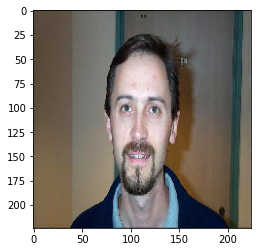

(16, 224, 224, 3)


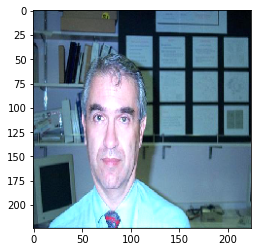

(16, 224, 224, 3)


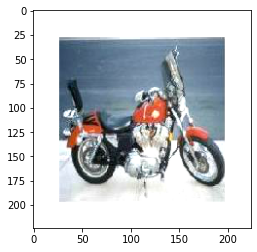

(16, 224, 224, 3)


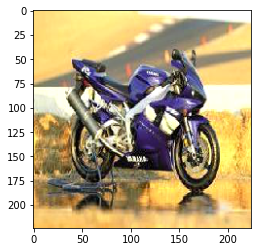

(16, 224, 224, 3)


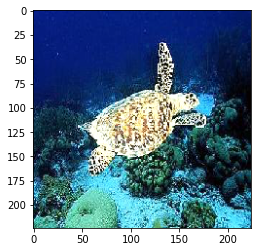

In [9]:
for _ in range(5):
    img, label = plot_generator.next()
    print(img.shape)   #  (16,224,224,3)
    plt.imshow(img[0])
    plt.show()

---

Her bir görsel üzerine uygulanabilmesi için standardizasyon ölçeklendirme yöntemi fonksiyonu oluşturuldu. Ayrıca Train, validation ve test generatorleri gerçekleştirildi. Bu generatorler epoch esnasında kullanılacak.

---



In [10]:
# Preprocessing the Training Set

from tensorflow.keras.preprocessing.image import  ImageDataGenerator
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

def standardize(image_data):
    image_data -= np.array(mean)
    image_data /= np.array(std)
    return image_data

#tf.keras.applications.efficientnet_v2.preprocess_input
train_datagen = ImageDataGenerator(dtype='float32',
                                   rescale=1.0/224.0,
                                   preprocessing_function=standardize,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10, # rotation
                                   vertical_flip=True,
                                   horizontal_flip=True
                                   )

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   shuffle=True,
                                                   target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
                                                   batch_size=16,
                                                   class_mode='categorical')

val_datagen = ImageDataGenerator( dtype='float32', 
                                  rescale=1.0/224.0,
                                  preprocessing_function=standardize
                                 )

val_generator = val_datagen.flow_from_directory(VALID_PATH,
                                                   shuffle=True,
                                                   target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
                                                   batch_size=16,
                                                   class_mode='categorical')



test_generator = val_datagen.flow_from_directory(TEST_PATH,
                                                   shuffle=False,
                                                   target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
                                                   batch_size=16,
                                                   class_mode='categorical')


Found 1346 images belonging to 9 classes.
Found 165 images belonging to 9 classes.
Found 174 images belonging to 9 classes.


---

CNN ağının kurulabilmesi için "efficientnet" kütüphanesi kuruldu.

---



In [11]:
! pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-gxwuslm_
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-gxwuslm_
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=40b0b819be3cb7d5b0f5115dae581793f5e448e8d37a324180b3772ec885114f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tehy0517/wheels/4f/5d/1a/f5568d40de3899e676981cbe16009738bab99940f320f402b5
Successfully built efficientnet


---

CNN ağı 4 adet Conv2D, 2 adet MaxPool2D, 2 adet Dropout, 1 Adet Flatten, 2 adet FC ve 1 adet Softmax içeriyor. Activation function olarak "swish" kullanıldı.

Optimizer:      Adam

Learning Rate:  1e-3




---



In [12]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

# import efficientnet.keras as efn

model = tf.keras.Sequential()

model.add(layers.Conv2D(input_shape=(224,224,3),filters=16,kernel_size=(3,3), padding="same", activation="swish"))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3), padding="same", activation="swish"))
model.add(layers.MaxPool2D(pool_size=(4,4)))
model.add(layers.Dropout(0.3) ) 
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="swish"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="swish"))
model.add(layers.MaxPool2D(pool_size=(4,4),strides=(4,4)))
model.add(layers.Dropout(0.4) ) 
model.add(layers.Flatten())
model.add(layers.Dense(units=512,activation="swish"))
model.add(layers.Dense(units=1024,activation="swish"))
model.add(layers.Dense(units=9, activation="softmax"))

model.compile(loss='categorical_crossentropy',  optimizer = Adam(learning_rate=1e-3), metrics=['accuracy',  tf.keras.metrics.AUC(), f1_m, precision_m, recall_m ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        9248      
                                                        

---

50 adet epoch olacak şekilde model eğitilmeye başladı.

---



In [13]:
%%time
# Running the model
import tensorflow as tf
model_name_save= '/content/CaltechTinySplit/CaltechTinySplit/Caltech_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name_save, save_freq='epoch', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')  
early_stop = tf.keras.callbacks.EarlyStopping(  monitor='val_accuracy', patience=70, verbose=1,  mode='max',restore_best_weights=False)
plateau = tf.keras.callbacks.ReduceLROnPlateau(  monitor='val_accuracy', factor=0.1, patience=50,  min_lr=5e-5, verbose=1,  mode='max')


history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[checkpoint, early_stop, plateau],  shuffle=True, verbose = 1)

Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 0.9778 - accuracy: 0.6999 - auc: 0.9338 - f1_m: 0.6912 - precision_m: 0.8104 - recall_m: 0.6169
Epoch 1: val_accuracy improved from -inf to 0.81212, saving model to /content/CaltechTinySplit/CaltechTinySplit/Caltech_model.hdf5
85/85 [==============================] - 28s 215ms/step - loss: 0.9778 - accuracy: 0.6999 - auc: 0.9338 - f1_m: 0.6912 - precision_m: 0.8104 - recall_m: 0.6169 - val_loss: 0.6413 - val_accuracy: 0.8121 - val_auc: 0.9706 - val_f1_m: 0.8430 - val_precision_m: 0.9326 - val_recall_m: 0.7716 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.8180 - auc: 0.9744 - f1_m: 0.8252 - precision_m: 0.8869 - recall_m: 0.7750
Epoch 2: val_accuracy did not improve from 0.81212
85/85 [==============================] - 18s 209ms/step - loss: 0.5965 - accuracy: 0.8180 - auc: 0.9744 - f1_m: 0.8252 - precision_m: 0.8869 - recall_m: 0.7750 - val_loss: 0.9329 - val_accu

---

"val_generator" ve "test_generator" skorları kullanıcıya bastırıldı. (Göz önünde bulundurulacak olan çıktılar test çıktılarıdır.)

---

In [14]:
val_scores = model.evaluate(val_generator)
test_scores = model.evaluate(test_generator)

11/11 [==============================] - 1s 91ms/step - loss: 0.5956 - accuracy: 0.9023 - auc: 0.9735 - f1_m: 0.9022 - precision_m: 0.9069 - recall_m: 0.8977


In [17]:
print('           Validation Scores')
print('Loss         : ', val_scores[0])
print('Accuracy     : ', val_scores[1])
print('Auc_1        : ', val_scores[2])
print('F1_m         : ', val_scores[3])
print('Precision_m  : ', val_scores[4])
print('Recall_m     : ', val_scores[5])

           Validation Scores
Loss         :  0.47330883145332336
Accuracy     :  0.9090909361839294
Auc_1        :  0.985360324382782
F1_m         :  0.9147727489471436
Precision_m  :  0.9147727489471436
Recall_m     :  0.9147727489471436


In [18]:
print('             Test Scores')
print('Loss         : ', test_scores[0])
print('Accuracy     : ', test_scores[1])
print('Auc_1        : ', test_scores[2])
print('F1_m         : ', test_scores[3])
print('Precision_m  : ', test_scores[4])
print('Recall_m     : ', test_scores[5])

             Test Scores
Loss         :  0.5955682396888733
Accuracy     :  0.9022988677024841
Auc_1        :  0.9735144972801208
F1_m         :  0.9021600484848022
Precision_m  :  0.9069055914878845
Recall_m     :  0.8977272510528564


---

Test çıktıları bir dizi haline dönüştürülüp ekrana bastırıldı.

---

In [19]:
W = np.array(test_scores)
print(W)

[0.59556824 0.90229887 0.9735145  0.90216005 0.90690559 0.89772725]


---

Confusion Matrix, hem dizi hem de görsel şeklinde kullanıcıya bastırıldı. Matrisin hesaplanılması için 174 train örneği ve batch size olan 16 değeri kullanıldı.

---

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

NUM_OF_TRAIN_SAMPLES = 174
BATCH_SIZE = 16

Y_pred = model.predict(test_generator, NUM_OF_TRAIN_SAMPLES // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

11/11 [==============================] - 1s 69ms/step
Confusion Matrix
[[42  0  0  0  0  2  0  0  0]
 [ 0 80  0  0  0  0  1  0  0]
 [ 0  1  3  0  0  0  1  0  0]
 [ 0  1  1  3  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  1  0]
 [ 0  0  0  0  0  6  2  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  4  1  3  0]
 [ 0  0  0  0  0  0  2  0  4]]


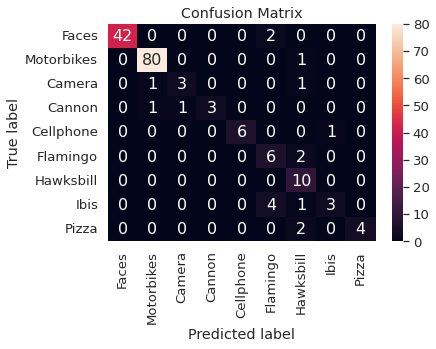

In [49]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

target_names = ['Faces', 'Motorbikes', 'Camera', 'Cannon', 'Cellphone', 'Flamingo', 'Hawksbill', 'Ibis', 'Pizza']
array = confusion_matrix(test_generator.classes, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in target_names],
                     columns = [i for i in target_names])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

---

Her bir sınıfın precision, recall, f1 skorları, skorlar aracılığı ile elde edilen accuracy skoru ve sınıfların sahip olduğu görsellerin adedini kullanıcıya bastıran Classification Report kullanıcıya bastırıldı.

---

In [24]:
print('Classification Report')
target_names = ['Faces', 'Motorbikes', 'Camera', 'Cannon', 'Cellphone', 'Flamingo', 'Hawksbill', 'Ibis', 'Pizza']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Faces       1.00      0.95      0.98        44
  Motorbikes       0.98      0.99      0.98        81
      Camera       0.75      0.60      0.67         5
      Cannon       1.00      0.60      0.75         5
   Cellphone       1.00      0.86      0.92         7
    Flamingo       0.50      0.75      0.60         8
   Hawksbill       0.59      1.00      0.74        10
        Ibis       0.75      0.38      0.50         8
       Pizza       1.00      0.67      0.80         6

    accuracy                           0.90       174
   macro avg       0.84      0.75      0.77       174
weighted avg       0.92      0.90      0.90       174



---

Train ve Validation kıyaslamasını rahatlıkla görebilmek amacıyla Accuracy, F1 ve AUC grafikleri çizildi.

---

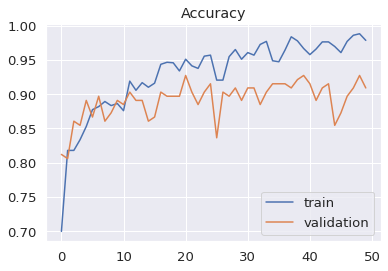

In [30]:
from matplotlib import pyplot

# plot accuracy during training
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

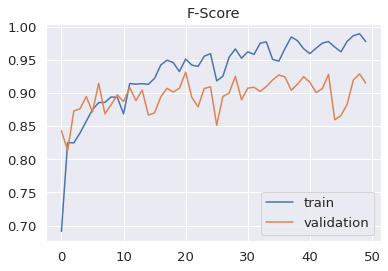

In [31]:
# plot f-score during training
pyplot.title('F-Score')
pyplot.plot(history.history['f1_m'], label='train')
pyplot.plot(history.history['val_f1_m'], label='validation')
pyplot.legend()
pyplot.show()

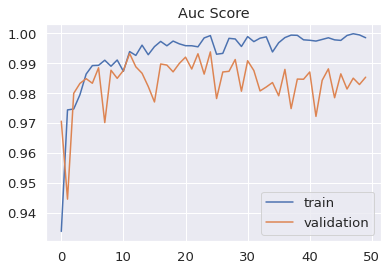

In [32]:
# plot auc score during training
pyplot.title('Auc Score')
pyplot.plot(history.history['auc'], label='train')
pyplot.plot(history.history['val_auc'], label='validation')
pyplot.legend()
pyplot.show()

---

9 sınıfın sahip olduğu AUC değerleri ve bu değerlerin bir bütün halinde oluşturduğu ROC grafiği çizildi. Ayrıca grafiğin AUC skoru kullanıcıya gösterildi.

---

11/11 [==============================] - 1s 71ms/step


ROC AUC score: 0.8710408423170649


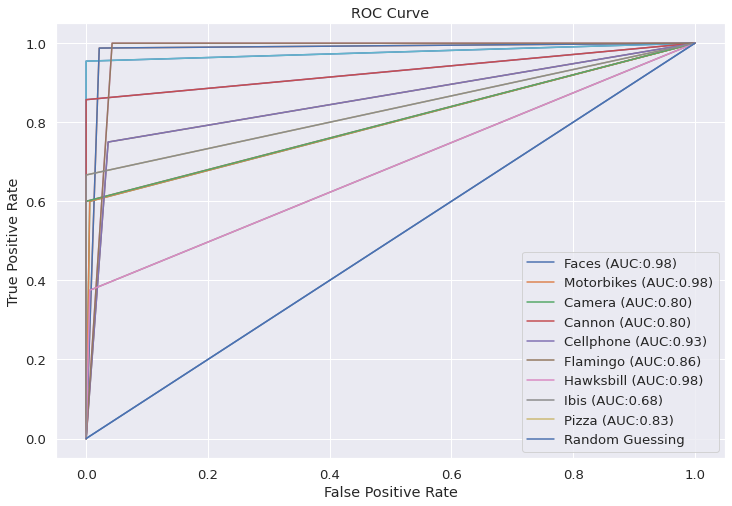

In [50]:
all_labels = val_generator.classes

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

target = ['Faces', 'Motorbikes', 'Camera', 'Cannon', 'Cellphone', 'Flamingo', 'Hawksbill', 'Ibis', 'Pizza']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    c_ax.legend()

    for (idx, c_label) in enumerate(target): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
   

# calling
plt.title("ROC Curve")
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

test_generator.reset() # resetting generator
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)

print('ROC AUC score:', multiclass_roc_auc_score(test_generator.classes, y_pred))